# ALK-5 Inhibition Prediction using Deep Learning
A small notebook to practice the design and implementation of Deep Learning Neural Networks. The ALK-5 (activin receptor type-5 kinase, or receptor-like activin kinase 5) is a member of the TGF-β superfamily which is of great interest for targeting in the treatment of some forms of cancer. In a cancer-related scenario, TGF-β presents an opposing role, promoting growth, invasion, and metastasis. The use of ALK-5 inihibitors has shown promising results in mice  for treating two types of myelofibrosis, a bone marrow blood cancer. This notebook aims to build and evaluate a deep learning neural network to predict the ALK-5 inhibition power for a given molecule, this model will be tested against other machine learning models (e.g. random forest). The idea for this notebook is based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7842961/
## Contents: 
1. [Data Collection and Preparation](#data-collection-and-preparation)
1. [Exploratory Data Analysis](#exploratory-data-analysis)
1. [Model Building and Evaluation](#model-building-and-evaluation)

## Data Collection and Preparation
----

### Data Collection
We will gather the data from the ChemBL database.

In [2]:
# importing the libraries that we will be using: 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# setting some defaults for data visualisation: 
color_palette = sns.color_palette(palette='coolwarm')
sns.set(style='ticks', context="paper", palette=color_palette)

from rdkit import Chem
from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors, DataStructs

# we will get data from the ChemBL database: 
from chembl_webresource_client.new_client import new_client

from tqdm import tqdm


In [2]:
chembl_id = 'CHEMBL4439'
# using this to get the bioactivity data for this protein: 
activity = new_client.activity
res = activity.filter(target_chembl_id=chembl_id).filter(standard_type='IC50')
activity_df = pd.DataFrame.from_dict(res)
activity_df.to_csv('activity_data.csv')

In [3]:
# we now have our data, we want to only include data which is from cellular and protein binding assays 
print('Shape before cleaning ' + str(activity_df.shape))
cleaned_activity_df = activity_df[activity_df['assay_type'].isin(['B'])]
print('Shape after considering only binding assays ' + str(cleaned_activity_df.shape))

Shape before cleaning (1730, 46)
Shape after considering only binding assays (1473, 46)


In [4]:
# we can drop the rest of the columns which we don't need, in this case we only need the IC50 value, the smiles and the ChEMBL id. 
cols = ['value','molecule_chembl_id','canonical_smiles']
cleaned_activity_df = cleaned_activity_df[cols]
cleaned_activity_df['value'] = cleaned_activity_df['value'].astype(float) # converting the values from strings to floats
cleaned_activity_df

,value,molecule_chembl_id,canonical_smiles
0,30.000,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
1,27.000,CHEMBL261454,c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1
2,0.034,CHEMBL129677,Cc1cccc(-c2[nH]ncc2-c2ccnc3ccccc23)n1
5,0.031,CHEMBL118928,Cc1cccc(-c2n[nH]cc2-c2ccc(O)cc2)n1
8,0.151,CHEMBL126789,Cc1cccc(-c2[nH]ncc2-c2ccc(F)c(F)c2)n1
...,...,...,...
1725,0.090,CHEMBL5220468,COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCC3)c1
1726,0.087,CHEMBL5218580,COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCCC3)c1
1727,0.087,CHEMBL5219198,N#Cc1c(NC(=O)/C=C/c2ccc(O)cc2)sc2c1CCC2
1728,0.170,CHEMBL2364611,Cc1cccc(-c2nn3c(c2-c2ccnc4ccc(C(N)=O)cc24)CCC3)n1


### Converting the IC50 values to pIC50 values:

This is the negative logarithm of IC50, making these figures easier to work with. 

In [5]:
# we will also need to cap the values at 1000000 otherwise we may get negative pIC50 numbers which are harder to interpret, so we need to normalise our values: 
def norm_value(input): 
    norm = []
    for value in input['value']:
        if value > 1000000: 
            value = 1000000
        if value <= 0: 
            value = 0.1
        norm.append(value)

    input['norm_value'] = norm
    x = input.drop('value', axis=1)
    return x

# converting from IC50 to pIC50 so mapping to a negative logarithmic scale for the data is distributed in a clearer many. 
def pIC50(input): 
    pIC50 = []

    for value in input['norm_value']: # mapping to the negative logarithmic scale
        molar = value * (10**-6) # converting from uM to M 
        pIC50.append(-np.log10(molar))
    
    input['pIC50'] = pIC50
    x = input.drop('norm_value', axis=1)

    return x

norm_df = norm_value(cleaned_activity_df)
cleaned_activity_df = pIC50(norm_df)
cleaned_activity_df

,molecule_chembl_id,canonical_smiles,pIC50
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.522879
1,CHEMBL261454,c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1,4.568636
2,CHEMBL129677,Cc1cccc(-c2[nH]ncc2-c2ccnc3ccccc23)n1,7.468521
5,CHEMBL118928,Cc1cccc(-c2n[nH]cc2-c2ccc(O)cc2)n1,7.508638
8,CHEMBL126789,Cc1cccc(-c2[nH]ncc2-c2ccc(F)c(F)c2)n1,6.821023
...,...,...,...
1725,CHEMBL5220468,COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCC3)c1,7.045757
1726,CHEMBL5218580,COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCCC3)c1,7.060481
1727,CHEMBL5219198,N#Cc1c(NC(=O)/C=C/c2ccc(O)cc2)sc2c1CCC2,7.060481
1728,CHEMBL2364611,Cc1cccc(-c2nn3c(c2-c2ccnc4ccc(C(N)=O)cc24)CCC3)n1,6.769551


### Cleaning the data: 
Here we are removing inorganic molecules, mixtures of molecules, as well as any duplicate data, or any invalid data.

In [6]:
# we can now check whether the dataframe contains inorganic molecules and if so, remove them. 
# Define the is_inorganic function
def is_inorganic_or_is_mixture(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None or all(atom.GetAtomicNum() not in [6, 1, 7, 8, 9, 15, 16] for atom in mol.GetAtoms()):
        return True
    else:
        fragments = Chem.GetMolFrags(mol, asMols=True)
        return len(fragments) > 1  # More than one fragment suggests a potential mixture

# Apply the is_inorganic function to filter out inorganic molecules
cleaned_activity_df['is_inorganic'] = cleaned_activity_df['canonical_smiles'].apply(is_inorganic_or_is_mixture)
filtered_df = cleaned_activity_df[~cleaned_activity_df['is_inorganic']]

# Drop the 'is_inorganic' column if you don't need it in the final DataFrame
filtered_df.drop(columns=['is_inorganic'], inplace=True)
print(f'After removing inorganic molecules there are {filtered_df.shape[0]} rows in the dataframe')

# Dropping null values: 
filtered_df = filtered_df.dropna()
print(f'After dropping null values there are {filtered_df.shape[0]} rows in the dataframe')

# finally we need to remove duplicates, these are where the smiles are the same
filtered_df = filtered_df.drop_duplicates(subset=['canonical_smiles'], keep='first')
print(f'After removing duplicates there are {filtered_df.shape[0]} rows in the dataframe')

After removing inorganic molecules there are 1468 rows in the dataframe
After dropping null values there are 1415 rows in the dataframe
After removing duplicates there are 1081 rows in the dataframe


/var/folders/vt/9hgnpt5x74b3vhw686s6hs8m0000gn/T/ipykernel_1009/3178608365.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['is_inorganic'], inplace=True)


In [53]:
# finally getting the pIC50 data as this will be used as the 'y' data: 
y_df = filtered_df[['molecule_chembl_id', 'pIC50']]
y_df.to_csv('y.csv')

### Calculating the descriptors that the NN will use: 
We only care about the canonical smiles and their respective pIC50 values, we will then convert the smiles into a molecular fingerprint (using Mordred).

In [39]:
cols = ['canonical_smiles', 'pIC50']
nn_df = filtered_df[cols]
nn_df = nn_df.reset_index()
nn_df = nn_df.drop(['index'], axis=1)

smiles = nn_df['canonical_smiles'].tolist()

In [18]:
from mordred import Calculator, descriptors
from multiprocessing import freeze_support

# Ensure multiprocessing support (used for parallel processing)
freeze_support()

# Initialize the Calculator with a list of desired descriptors and ignore 3D coordinates
calc = Calculator(descriptors, ignore_3D=True)

# Convert SMILES strings to RDKit molecule objects
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

# Calculate the descriptors for the molecules using the Calculator
calculated_descriptors = calc.pandas(mols)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Select only numeric columns from the calculated descriptors DataFrame
calculated_descriptors = calculated_descriptors.select_dtypes(include=numerics)
calculated_descriptors.to_csv('all_descriptors.csv', index=False)

100%|██████████| 1081/1081 [24:31<00:00,  1.36s/it]


### Dropping Duplicate Descriptors
We will also remove pairs of calculated descriptors with an R^2 value > 0.95.

In [47]:
from itertools import combinations
from sklearn.metrics import r2_score

x_df = pd.read_csv('all_descriptors.csv')
print(f'Columns before duplicates removed = {x_df.shape[1]}')

pairs = list(combinations(x_df.columns, 2))

remove = []

for pair in tqdm(pairs): # this is removing any pairs that are highly correlated 

    a0 = x_df[pair[0]].values
    a1 = x_df[pair[1]].values

    if r2_score(a1, a0) > 0.95:
        remove.append(pair[0])

remove = list(dict.fromkeys(remove))

x_df.drop(columns=remove, inplace=True)
print(f'Columns after duplicates removed = {x_df.shape[1]}')

x_df.to_csv('unique_descriptors.csv')

Columns before duplicates removed = 1419


100%|██████████| 1006071/1006071 [03:09<00:00, 5318.89it/s]


Columns after duplicates removed = 1039


### Normalising the descriptors
To improve the numerical stability, all resulting descriptors were then standardized by z-score, i.e. they were centered and scaled to achieve zero mean and unit variance.

In [121]:
from sklearn.preprocessing import StandardScaler

x_df = pd.read_csv('unique_descriptors.csv')

# Standardize the descriptors by converting them to z-scores
scaler = StandardScaler()
scaled_descriptors = pd.DataFrame(scaler.fit_transform(x_df), columns=x_df.columns)
# Save the standardized descriptors to a CSV file without an index column
scaled_descriptors.to_csv('unique_descriptors.csv', index=False)

### RReliefF feature selection
This is a filter method that scores features based on the differences on feature values between nearest-neighbor instance pairs. We will take the 50 best features/descriptors to be used as the starting point when optimising the NN later.

In [6]:
np.seterr(divide='ignore')

class RReliefF:

    def __init__(self, k=10, sigma=30):
        """
        Initialize the ReliefF feature selection algorithm.

        Parameters:
        - k (int): The number of nearest neighbors to consider.
        - sigma (float): The width parameter for the Gaussian distance weight.
        """

        # Set the parameters
        self.k = k
        self.sigma = sigma

        # Initialize the weights and weight tracking variables
        self.weights = None
        self.w_track = None

        # Create a list of distance weights using a Gaussian function
        distance_list = [np.exp(-((n + 1) / sigma) ** 2) for n in range(k)]
        self._distance = distance_list / np.sum(distance_list)

    def fit(self, x, y):
        """
        Fit the ReliefF algorithm to the given data.

        Parameters:
        - x (numpy.ndarray): The feature matrix.
        - y (numpy.ndarray): The target labels.

        Note: x should have shape (number of samples, number of features).
        """

        m = x.shape[0]  # Number of samples

        # Initialize the weight vector and weight tracking matrix
        self.weights = np.zeros([x.shape[1], 1])
        self.w_track = np.zeros([m, x.shape[1]])

        n_dc = 0  # Distance sum for different classes
        n_da = np.zeros([x.shape[1], 1])  # Distance sum for each feature
        n_dcandda = np.zeros([x.shape[1], 1])  # Distance sum for different classes and each feature

        y_range = np.max(y) - np.min(y)  # Range of target values

        for i in tqdm(range(m)):  # Loop over each sample in the dataset (with tqdm for progress tracking)

            # Get the current sample's feature vector (x_i) for sample 'i'
            b = x[i, :]

            # Calculate the squared differences between the current sample and all other samples
            difference = (x - b) ** 2

            # Sum the squared differences along each row to find the overall difference
            sum_difference = np.sum(difference, axis=1)

            # Sort the indices of samples based on their sum of squared differences
            neighbour_index = np.argsort(sum_difference)

            # Exclude the current sample itself (the first index) and get its neighbors
            neighbours = x[neighbour_index][1:]

            # Select the top 'k' nearest neighbors
            knn = neighbours[:self.k]

            # Separate the feature vectors of the 'k' nearest neighbors (x_knn)
            x_knn, neighbour_index = knn, neighbour_index[1:]

            # Get the corresponding target values for the nearest neighbors (y_knn)
            y_knn = y[neighbour_index]

            # Get the feature vector (x_i) and target value (y_i) of the current sample
            x_i = x[i, :]
            y_i = y[i]

            for j in range(self.k):  # Loop over the 'k' nearest neighbors

                # Calculate and accumulate the weighted difference in target values (n_dc)
                n_dc += (np.abs(y_i - y_knn[j]) / y_range) * self._distance[j]

                for a in range(x.shape[1]):  # Loop over each feature

                    # Calculate the absolute difference between the current feature and its neighbor
                    diff = np.abs(x_i[a] - x_knn[j][a]) / (np.max(x[:, a]) - np.min(x[:, a]))

                    # Accumulate the weighted difference in the feature values (n_da)
                    n_da[a] = n_da[a] + self._distance[j] * diff

                    # Accumulate the weighted difference in target values and feature values (n_dcandda)
                    n_dcandda[a] = n_dcandda[a] + (np.abs(y_i - y_knn[j]) / y_range) * self._distance[j] * diff

            for a in range(x.shape[1]):  # Loop over each feature

                # Calculate and store the feature weight for the current sample (self.w_track)
                self.w_track[i, a] = n_dcandda[a] / n_dc - ((n_da[a] - n_dcandda[a]) / (m - n_dc))

        # Calculate the final feature weights for the entire dataset (self.weights)
        for a in range(x.shape[1]):

            # Normalize the accumulated feature weight using n_dc and n_da
            self.weights[a] = n_dcandda[a] / n_dc - ((n_da[a] - n_dcandda[a]) / (m - n_dc))

x = StandardScaler().fit_transform(pd.read_csv('unique_descriptors.csv').values)
y = pd.read_csv('y.csv', index_col='molecule_chembl_id').drop(['Unnamed: 0'], axis=1).values

method = RReliefF()
method.fit(x, y)

  0%|          | 0/1081 [00:00<?, ?it/s]/var/folders/vt/9hgnpt5x74b3vhw686s6hs8m0000gn/T/ipykernel_2138/4116581197.py:87: RuntimeWarning: invalid value encountered in scalar divide
  diff = np.abs(x_i[a] - x_knn[j][a]) / (np.max(x[:, a]) - np.min(x[:, a]))
100%|██████████| 1081/1081 [02:43<00:00,  6.59it/s]


In [ ]:
data = dict(Descriptor=list(pd.read_csv('unique_descriptors.csv').columns),
            Values=list(np.ravel(method.weights)))

df = pd.DataFrame.from_dict(data)
df = df[df['Descriptor'] != 'Unnamed: 0']
df = df[df['Descriptor'] != 'n7FAHRing'] # upon viewing the dataframe we can see that one fo the features, 'n7FAHRing', has a null value, so we remove this. 
df.to_csv('rrelieff_results.csv', index=False)

In [22]:
df = pd.read_csv('rrelieff_results.csv')
df = df.sort_values(by='Values', ascending=False) # sorting by the 'best' features.
optimum_descriptors_list = df[:50]['Descriptor'].values # selecting only the top 50 features for the optimization finder.

descriptors_df = pd.read_csv('unique_descriptors.csv')
descriptor_cols = list(optimum_descriptors_list)
rrelieff_descriptors_df = descriptors_df[descriptor_cols]
rrelieff_descriptors_df.to_csv('rrelieff_descriptors.csv')

,BCUTi-1l,NaasN,BCUTp-1h,SaaNH,NaaNH,SaasN,n10FaHRing,nFHRing,n6aHRing,BCUTv-1h,...,nS,SMR_VSA9,AATSC0p,GATS5i,MATS7p,MATS5i,PEOE_VSA3,SaaS,SlogP_VSA6,AATS7i
0,-1.460910,-1.029190,1.443702,1.331505,1.245930,-1.036072,-0.586965,-1.633657,-0.624493,1.425818,...,1.04385,1.270859,1.446448,-2.842247,-1.026536,1.599762,0.014419,-0.427387,1.052665,-2.613198
1,0.592260,-1.029190,-0.655903,1.073449,1.245930,-1.036072,1.703680,0.185069,0.600692,-0.693697,...,-0.60586,0.079240,-0.774336,1.387380,1.090476,-1.359671,-1.279570,-0.427387,0.436558,0.727447
2,0.592256,-1.029190,-0.655185,1.153657,1.245930,-1.036072,1.703680,0.185069,0.600692,-0.693576,...,-0.60586,0.079240,-0.635602,1.786561,0.842384,-2.005136,-1.279570,-0.427387,0.084070,0.819579
3,0.650984,-1.029190,-0.703249,1.028563,1.245930,-1.036072,-0.586965,-1.633657,-0.624493,-0.704603,...,-0.60586,0.680865,-0.555356,1.258215,-1.278977,-0.937363,-1.279570,-0.427387,-0.613483,0.107479
4,0.651219,-1.029190,-0.701442,1.013893,1.245930,-1.036072,-0.586965,-1.633657,-0.624493,-0.704507,...,-0.60586,0.079240,-0.245422,-0.803192,0.359908,-1.184873,-0.067513,-0.427387,-0.958548,2.738531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,0.643190,2.014734,-0.212763,-0.747320,-0.749404,1.182554,-0.586965,0.185069,0.600692,0.232560,...,-0.60586,-0.517254,-0.200369,-0.741636,-0.335864,0.988074,-0.011730,-0.427387,-0.325917,0.288053
1077,0.643180,2.014734,-0.212737,-0.747320,-0.749404,1.268119,-0.586965,0.185069,-0.624493,0.232560,...,-0.60586,-0.517254,-0.033490,-0.649913,-0.535046,0.958023,-0.011730,-0.427387,0.004305,-0.271511
1078,-1.531809,-1.029190,1.473324,-0.747320,-0.749404,-1.036072,-0.586965,0.185069,-1.849679,1.428651,...,1.04385,-0.438361,1.503470,0.885046,2.340913,-0.923034,-1.279570,1.528440,-2.000618,0.250696
1079,-1.531813,-1.029190,1.473328,-0.747320,-0.749404,-1.036072,-0.586965,0.185069,-1.849679,1.428651,...,1.04385,-0.438361,1.431762,1.296712,2.212179,-1.218428,-1.279570,1.545780,-2.000618,0.500927


### Sequential Backwards Feature Selection
The process of iterating through all of the features, removing it and checking the impact on the error. If the error decreases, then update the 'best error' with this value and the 'worst feature' with this feature. After cycling through all of the features remove the worst feature. Continue until the error no longer decreases.

In [5]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dropout, Dense

In [43]:
# Configure early stopping for the Keras model
monitor = tf.keras.callbacks.EarlyStopping(
    monitor='loss',           # Monitor the training loss
    patience=50,              # Number of epochs with no improvement to wait before stopping
    min_delta=0.001,           # Minimum change in loss to be considered an improvement
    verbose=1,                 # 0: No output, 1: Progress bar, 2: One line per epoch
    mode='auto',               # Automatically detect loss improvement direction
    restore_best_weights=True  # Restore the model with the best weights observed during training
)

# Set a random seed for reproducibility
seed = 7
np.random.seed(seed)

# Load the target values from 'y.csv'
path_y = 'y.csv'
y_df = pd.read_csv(path_y)
y = y_df['pIC50'].values

# Load the feature values from 'rrelieff.csv'
path_x = 'rrelieff_descriptors.csv'
x_df = pd.read_csv(path_x)
x = x_df.values

# Define the path to save the results
path_r = 'sbfs.csv'

# Standardize the feature values using StandardScaler
x = StandardScaler().fit_transform(x)

# Define a function to create the Keras regression model
def create_model(input_dim):
    model = Sequential()
    
    model.add(Dense(64, kernel_initializer='he_uniform', input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    layers=8
    while layers > 1: 
        layers -= 1
        model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
        model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer='he_uniform', activation='linear'))
    
    # Use a learning rate scheduler to adjust learning rates during training
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=1000,
        decay_rate=0.9
    )
    
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule))
    
    return model

# Split the data into training and holdout sets (2/3 training, 1/3 holdout)
x, x_holdout, y, y_holdout = train_test_split(x, y, test_size=1/3)  

# Create a Keras regression model
input_dim = x.shape[1]
model = create_model(input_dim)

# Initialize variables for feature selection
selected_features = list(range(input_dim))
best_loss = float('inf')

# Perform Sequential Backward Feature Selection, this is done manually since SFS packages were causing issues. 
while len(selected_features) > 1:  # Stop when only one feature is left
    current_loss = float('inf')
    worst_feature = None
    
    for feature in selected_features:
        features_to_use = selected_features.copy()
        features_to_use.remove(feature)
        
        # Create a new model without the feature to evaluate its performance
        new_x = x[:, features_to_use]
        new_model = create_model(new_x.shape[1])
        
        new_model.fit(new_x, y, epochs=200, batch_size=64, callbacks=[monitor], verbose=0)
        new_loss = new_model.evaluate(new_x, y, verbose=0)
        
        if new_loss < current_loss:
            current_loss = new_loss
            worst_feature = feature
    
    if current_loss < best_loss:
        best_loss = current_loss
        selected_features.remove(worst_feature)
    else:
        # No improvement in loss, stop feature selection
        break

# Convert the selected feature indices to column names
selected_feature_names = x_df.columns[selected_features]

# Save the selected features to 'sbfs.csv' file
selected_features_df = x_df[selected_feature_names]
selected_features_df.to_csv(path_or_buf=path_r, sep=',', header=True, index=False, encoding='utf-8')

Restoring model weights from the end of the best epoch: 150.
Epoch 200: early stopping
Restoring model weights from the end of the best epoch: 135.
Epoch 185: early stopping
Restoring model weights from the end of the best epoch: 124.
Epoch 174: early stopping
Restoring model weights from the end of the best epoch: 97.
Epoch 147: early stopping
Restoring model weights from the end of the best epoch: 120.
Epoch 170: early stopping
Restoring model weights from the end of the best epoch: 133.
Epoch 183: early stopping
Restoring model weights from the end of the best epoch: 147.
Epoch 197: early stopping
Restoring model weights from the end of the best epoch: 97.
Epoch 147: early stopping
Restoring model weights from the end of the best epoch: 148.
Epoch 198: early stopping


In [44]:
selected_features_df.drop('Unnamed: 0', axis=1)

,BCUTi-1l,NaasN,BCUTp-1h,SaaNH,NaaNH,SaasN,n10FaHRing,nFHRing,n6aHRing,BCUTv-1h,...,PEOE_VSA10,nS,SMR_VSA9,AATSC0p,GATS5i,MATS7p,MATS5i,PEOE_VSA3,SlogP_VSA6,AATS7i
0,-1.460910,-1.029190,1.443702,1.331505,1.245930,-1.036072,-0.586965,-1.633657,-0.624493,1.425818,...,0.993137,1.04385,1.270859,1.446448,-2.842247,-1.026536,1.599762,0.014419,1.052665,-2.613198
1,0.592260,-1.029190,-0.655903,1.073449,1.245930,-1.036072,1.703680,0.185069,0.600692,-0.693697,...,-0.775162,-0.60586,0.079240,-0.774336,1.387380,1.090476,-1.359671,-1.279570,0.436558,0.727447
2,0.592256,-1.029190,-0.655185,1.153657,1.245930,-1.036072,1.703680,0.185069,0.600692,-0.693576,...,-1.600220,-0.60586,0.079240,-0.635602,1.786561,0.842384,-2.005136,-1.279570,0.084070,0.819579
3,0.650984,-1.029190,-0.703249,1.028563,1.245930,-1.036072,-0.586965,-1.633657,-0.624493,-0.704603,...,0.057950,-0.60586,0.680865,-0.555356,1.258215,-1.278977,-0.937363,-1.279570,-0.613483,0.107479
4,0.651219,-1.029190,-0.701442,1.013893,1.245930,-1.036072,-0.586965,-1.633657,-0.624493,-0.704507,...,-1.600220,-0.60586,0.079240,-0.245422,-0.803192,0.359908,-1.184873,-0.067513,-0.958548,2.738531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,0.643190,2.014734,-0.212763,-0.747320,-0.749404,1.182554,-0.586965,0.185069,0.600692,0.232560,...,0.191047,-0.60586,-0.517254,-0.200369,-0.741636,-0.335864,0.988074,-0.011730,-0.325917,0.288053
1077,0.643180,2.014734,-0.212737,-0.747320,-0.749404,1.268119,-0.586965,0.185069,-0.624493,0.232560,...,0.191047,-0.60586,-0.517254,-0.033490,-0.649913,-0.535046,0.958023,-0.011730,0.004305,-0.271511
1078,-1.531809,-1.029190,1.473324,-0.747320,-0.749404,-1.036072,-0.586965,0.185069,-1.849679,1.428651,...,1.670106,1.04385,-0.438361,1.503470,0.885046,2.340913,-0.923034,-1.279570,-2.000618,0.250696
1079,-1.531813,-1.029190,1.473328,-0.747320,-0.749404,-1.036072,-0.586965,0.185069,-1.849679,1.428651,...,1.670106,1.04385,-0.438361,1.431762,1.296712,2.212179,-1.218428,-1.279570,-2.000618,0.500927


### Creating the dataframe to perform EDA on

In [7]:
# we now have our dataframe, performing some exploratory data analysis: 
data_vis_df = filtered_df.copy()

# defining some helper functions to generate useful metrics to visualise in the dataset: 
from rdkit.Chem import Lipinski
def lipinski(smiles, verbose=False): 
    moldata = []
    # this gets each element in the smiles code
    for elem in smiles:
        if elem is not None:
            mol = Chem.MolFromSmiles(elem)
            moldata.append(mol)
    
    base_data = np.arange(1,1)
    i = 0 
    for mol in moldata:
        # get the relevant parameters for each element
        desc_mol_weight = Descriptors.MolWt(mol)
        desc_hb_donor = Lipinski.NumHDonors(mol)
        desc_hb_acceptor = Lipinski.NumHAcceptors(mol)
        desc_partit = Descriptors.MolLogP(mol)
    
        row = np.array([desc_mol_weight, desc_partit, desc_hb_donor, desc_hb_acceptor])

        if i==0:
            base_data = row
        else: 
            base_data = np.vstack([base_data, row]) # stack the rows of data
        i=i+1

    cols = ['molecular_weight', 'logP', 'num_H_bond_donors', 'num_H_bond_acceptors']
    descriptors = pd.DataFrame(data=base_data, columns=cols, index=smiles) # convert to a dataframe

    return descriptors

lipinski_df = lipinski(data_vis_df['canonical_smiles'])
lipinski_df

,molecular_weight,logP,num_H_bond_donors,num_H_bond_acceptors
canonical_smiles,,,,
C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1,377.444,4.68220,1.0,3.0
c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1,272.311,3.68690,1.0,3.0
Cc1cccc(-c2[nH]ncc2-c2ccnc3ccccc23)n1,286.338,3.99532,1.0,3.0
Cc1cccc(-c2n[nH]cc2-c2ccc(O)cc2)n1,251.289,3.15272,2.0,3.0
Cc1cccc(-c2[nH]ncc2-c2ccc(F)c(F)c2)n1,271.270,3.72532,1.0,2.0
...,...,...,...,...
Cc1ncc(-c2cc(Cl)ccc2F)cc1-n1c(=O)n(CC(N)=O)c2cnccc21,411.824,2.83542,1.0,6.0
Cc1ncc(-c2cc(Cl)ccc2F)cc1-n1c(=O)n(CC(N)=O)c2ccccc21,410.836,3.44042,1.0,5.0
COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCC3)c1,354.431,3.77758,1.0,5.0


In [8]:
# merging the dataframes 
data_vis_df_merged = pd.merge(lipinski_df, filtered_df, on='canonical_smiles')
data_vis_df_merged

,canonical_smiles,molecular_weight,logP,num_H_bond_donors,num_H_bond_acceptors,molecule_chembl_id,pIC50
0,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.68220,1.0,3.0,CHEMBL10,4.522879
1,c1ccc(-c2n[nH]cc2-c2ccnc3ccccc23)nc1,272.311,3.68690,1.0,3.0,CHEMBL261454,4.568636
2,Cc1cccc(-c2[nH]ncc2-c2ccnc3ccccc23)n1,286.338,3.99532,1.0,3.0,CHEMBL129677,7.468521
3,Cc1cccc(-c2n[nH]cc2-c2ccc(O)cc2)n1,251.289,3.15272,2.0,3.0,CHEMBL118928,7.508638
4,Cc1cccc(-c2[nH]ncc2-c2ccc(F)c(F)c2)n1,271.270,3.72532,1.0,2.0,CHEMBL126789,6.821023
...,...,...,...,...,...,...,...
1076,Cc1ncc(-c2cc(Cl)ccc2F)cc1-n1c(=O)n(CC(N)=O)c2c...,411.824,2.83542,1.0,6.0,CHEMBL4750687,3.610834
1077,Cc1ncc(-c2cc(Cl)ccc2F)cc1-n1c(=O)n(CC(N)=O)c2c...,410.836,3.44042,1.0,5.0,CHEMBL4741904,2.000000
1078,COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCC3)c1,354.431,3.77758,1.0,5.0,CHEMBL5220468,7.045757
1079,COc1ccc(OC)c(/C=C/C(=O)Nc2sc3c(c2C#N)CCCC3)c1,368.458,4.16768,1.0,5.0,CHEMBL5218580,7.060481


## Exploratory Data Analysis: 
----
Looking at the distribution and correlation of the different numeric features with the pIC50 values, to determine if there is any high level relationship that we can see.

### Distribution of some features


pIC50 stats:
count    1081.000000
mean        5.412657
std         1.773641
min         0.939302
25%         4.309804
50%         5.301030
75%         6.958607
max         9.259637
Name: pIC50, dtype: float64

molecular_weight stats:
count    1081.000000
mean      409.365045
std        68.251521
min       221.263000
25%       357.391000
50%       415.497000
75%       452.537000
max       697.880000
Name: molecular_weight, dtype: float64

logP stats:
count    1081.000000
mean        4.327365
std         1.044081
min         1.020900
25%         3.705920
50%         4.339800
75%         5.037020
max         7.408400
Name: logP, dtype: float64

num_H_bond_donors stats:
count    1081.000000
mean        1.483811
std         0.947691
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: num_H_bond_donors, dtype: float64

num_H_bond_acceptors stats:
count    1081.000000
mean        5.972248
std         1.452063
min         2.000000
25%

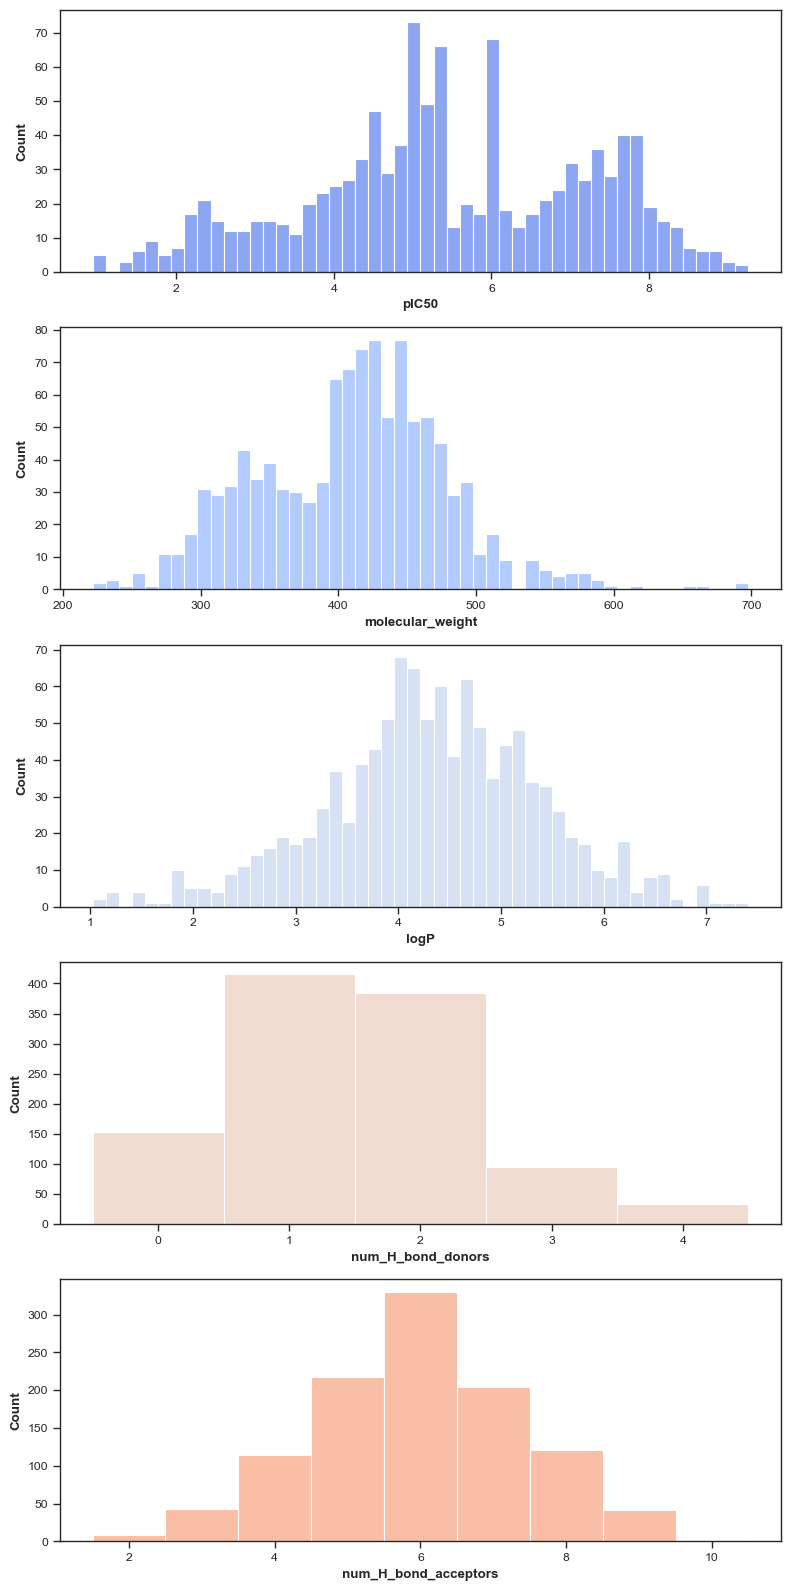

In [9]:
dist_features = ['pIC50', 'molecular_weight', 'logP', 'num_H_bond_donors', 'num_H_bond_acceptors']
fig, axs = plt.subplots(nrows=len(dist_features), figsize=(8,16))
for i, feature in enumerate(dist_features):
    is_discrete = False
    if ['num_H_bond_donors', 'num_H_bond_acceptors'].__contains__(feature):
        is_discrete=True
    color=color_palette[int(i/len(dist_features) * len(color_palette))] # setting the color

    sns.histplot(data=data_vis_df_merged, x=feature, bins=50, ax=axs[i], color=color, discrete=is_discrete)
    
    axs[i].set_xlabel(f'{feature}', fontweight='bold')
    axs[i].set_ylabel(f'Count', fontweight='bold')

    print('\n' + f'{feature} stats:')
    print(data_vis_df_merged[feature].describe())

fig.tight_layout()

What kind of things can we say about this? All the columns seem to follow a (very) rough gaussian distribution, in particular the number of hydrogen bond acceptors which is almost perfectly symmetrical about 6. logP has a mean of just above 4 (4.32), but is roughly gaussian, molecular weight skews slightly negatively from its mean, whilst the pIC50 values have a flatter distribution with longer tails, though with peaks around 5.3-6. 

### Correlation with pIC50

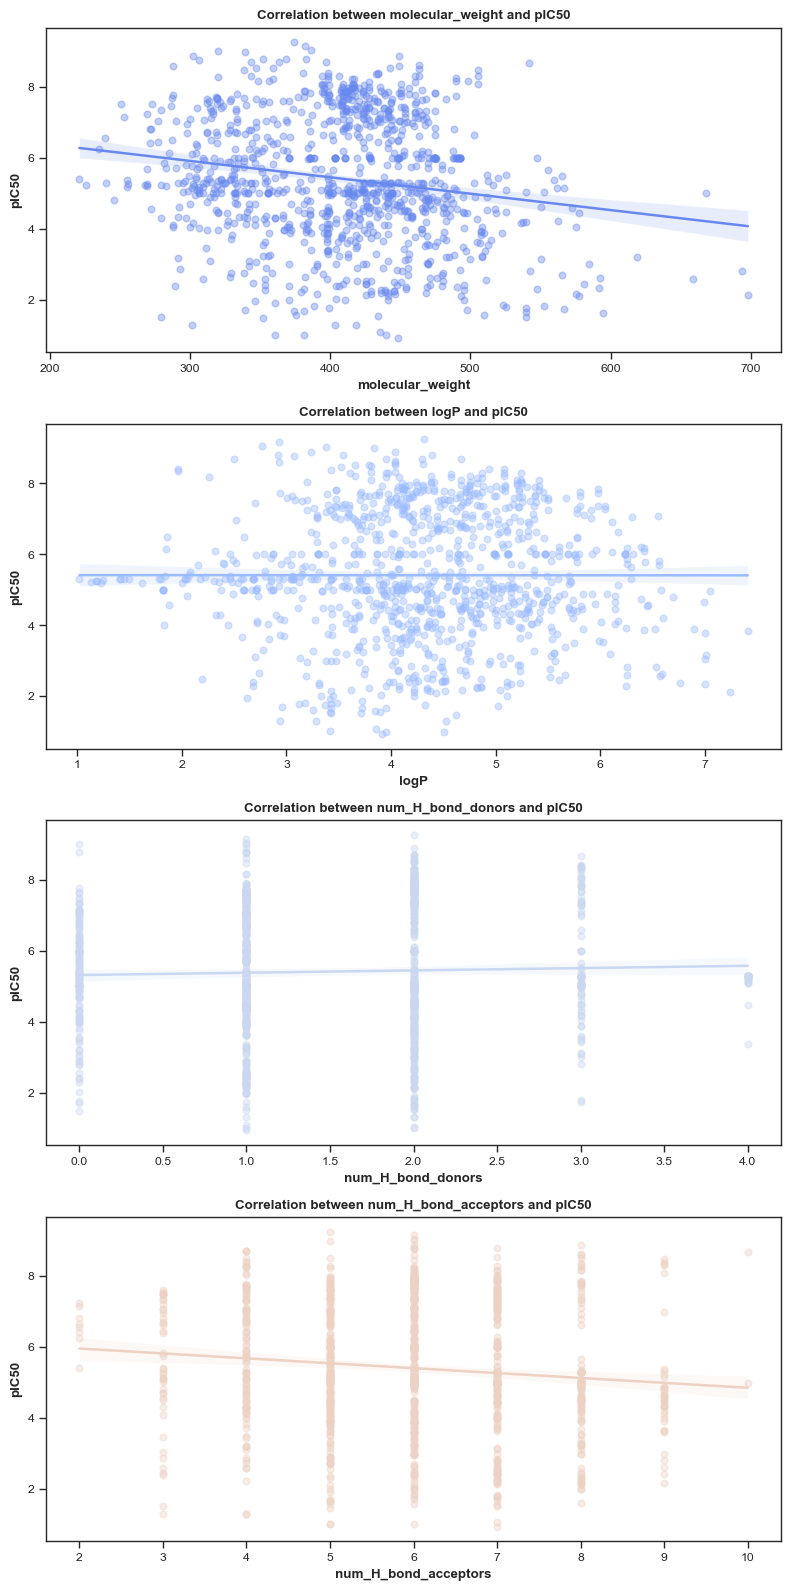

In [10]:
# next plotting the correlation between pIC50 and these features:
fig, axs = plt.subplots(nrows=len(dist_features[1:]), figsize=(8,16))
for i, feature in enumerate(dist_features[1:]):
    color=color_palette[int(i/len(dist_features) * len(color_palette))] # setting the color

    sns.regplot(data=data_vis_df_merged, x=feature, y='pIC50', ax=axs[i], color=color, scatter_kws={'alpha':0.4})
    
    axs[i].set_xlabel(f'{feature}', fontweight='bold')
    axs[i].set_ylabel(f'pIC50', fontweight='bold')
    axs[i].set_title(f'Correlation between {feature} and pIC50', fontweight='bold')

fig.tight_layout()

The lack of any clear correlation between the features and the pIC50 value makes a good case for using deep learning (or certainly using molecular fingerprints), since any of these features aren't likely to be stong predictors for pIC50 values at first glance.

Text(0.5, 1.0, 'Correlation Heatmap')

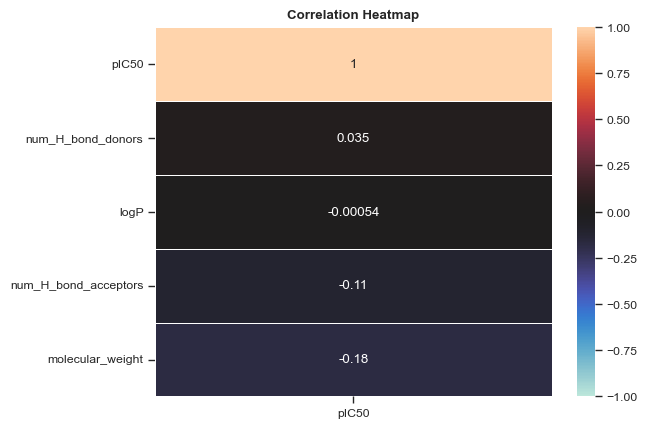

In [11]:
corr = data_vis_df_merged[dist_features].corr()
ax = sns.heatmap(
    corr[['pIC50']].sort_values(by='pIC50', ascending=False), 
    vmin=-1, vmax=1, center=0,
    linewidths=0.5,
    cmap=plt.set_cmap('coolwarm'),
    annot=True,
)
ax.set_title('Correlation Heatmap', fontweight='bold')

### Tanimoto similarity scores

In [42]:
# Generate molecular fingerprints using Morgan algorithm with radius=2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),
                                                2) for smiles in data_vis_df_merged['canonical_smiles']]
similarity_scores = [] # calculating the tanimoto similarity scores for the combinations
for fp1, fp2 in combinations(fps, 2):
    similarity_score = DataStructs.TanimotoSimilarity(fp1, fp2)
    similarity_scores.append(similarity_score)

Text(0.5, 0, 'Similarity score')

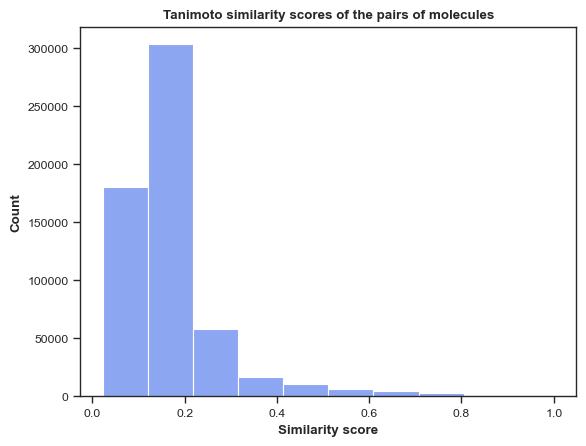

In [34]:
sns.histplot(similarity_scores, bins=10)
plt.title('Tanimoto similarity scores of the pairs of molecules', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Similarity score', fontweight='bold')

In [66]:
y = pd.read_csv('y.csv', index_col='molecule_chembl_id').drop(['Unnamed: 0'], axis=1).values


array([[4.52287875],
       [4.56863624],
       [7.46852108],
       ...,
       [7.04575749],
       [7.06048075],
       [7.06048075]])

array([[0.00000000e+00, 4.52287875e+00],
       [1.00000000e+00, 4.56863624e+00],
       [2.00000000e+00, 7.46852108e+00],
       ...,
       [1.72500000e+03, 7.04575749e+00],
       [1.72600000e+03, 7.06048075e+00],
       [1.72700000e+03, 7.06048075e+00]])

In [99]:
path_x = 'rrelieff.csv'
x_df = pd.read_csv(path_x)
x_df

,Descriptor,Values
0,nAcid,0.006772
1,nBase,0.020828
2,SpMax_A,0.014344
3,SpDiam_A,0.014925
4,SpAD_A,0.004170
...,...,...
1034,WPol,0.005868
1035,Zagreb1,0.004437
1036,Zagreb2,0.005044
1037,mZagreb1,0.003193


In [102]:
y_df = pd.read_csv(path_y)
y_df

,Unnamed: 0,molecule_chembl_id,pIC50
0,0,CHEMBL10,4.522879
1,1,CHEMBL261454,4.568636
2,2,CHEMBL129677,7.468521
3,5,CHEMBL118928,7.508638
4,8,CHEMBL126789,6.821023
...,...,...,...
1076,1721,CHEMBL4750687,3.610834
1077,1722,CHEMBL4741904,2.000000
1078,1725,CHEMBL5220468,7.045757
1079,1726,CHEMBL5218580,7.060481


## Model Building and Evaluation
----
Finally we are in a position to build the neural network, although the network in the literature is trained for longer than this one due to my inferior computational power :( so we would expect that the literature NN will perform better than mine.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold

### Optimising the different model's parameters
We will also visualise the results of changing the number of epochs over which the model is trained, the learning rate, the batch_size, the number of layers, the number of units, the optimzer and the initializer.

#### Optimising the 2 ML model parameters
First optimising the random forest model: 

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

seed = 7
np.random.seed(seed)

# Load the target values from 'y.csv'
path_y = 'y.csv'
y_df = pd.read_csv(path_y)
y = y_df['pIC50'].values

# Load the feature values from 'sbfs.csv'
path_x = 'sbfs.csv'
x_df = pd.read_csv(path_x)
x_df = x_df.drop('Unnamed: 0', axis=1)
x = x_df.values

x = StandardScaler().fit_transform(x)

x, x_holdout, y, y_holdout = train_test_split(x, y, test_size=0.333)

n_estimators = [2, 4, 8, 16, 32, 64, 128, 248, 512, 1024, 2048, 4096, 8192]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_split = [2, 4, 6]

parameters = dict(n_estimators=n_estimators, max_features=max_features, min_samples_split=min_samples_split)

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=2)
grid_result = grid.fit(x, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 390 candidates, totalling 1950 fits
[CV] END max_features=0.1, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=4; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=4; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END max_features=0

/Users/mattball/Documents/GitHub/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_features=0.1, min_samples_split=2, n_estimators=8192; total time=  23.1s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=2048; total time=   5.8s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8192; total time=  23.7s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=2048; total time=   5.9s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=2048; total time=   5.5s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=2048; total time=   5.1s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8192; total time=  23.1s
[CV] END max_features=0.1, min_samples_split=2, n_estimators=8192; total time=  23.2s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=4096; total time=   9.9s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=4096; total time=   9.9s
[CV] END max_features=0.1, min_samples_split=4, n_estimators=4096; total time=  10.0s
[CV] END max_features=0.1, min_samples_split=6, n_esti

The best parameters for the random forest are: {'max_features': 0.3, 'min_samples_split': 2, 'n_estimators': 4096}.
Now repeating the same process for the SVM model: 

In [4]:
x = StandardScaler().fit_transform(x)

x, x_holdout, y, y_holdout = train_test_split(x, y, test_size=1/3)

kernel = ['poly', 'rbf']
degree = [2, 3, 4, 5, 6]
C = [0.1, 0.5, 1, 2, 4, 6, 8, 10]
epsilon = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

parameters = dict(kernel=kernel, degree=degree, C=C, epsilon=epsilon)

model = SVR()
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=2)
grid_result = grid.fit(x, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV] END .........C=0.1, degree=2, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.04, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=0.02, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.04, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, epsilon=0.02, kernel=rbf; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.04, kernel=poly; total time=   0.0s
[CV] END .........C=0.1, degree=2, epsilon=0.

This time the best parameters were {'C': 4, 'degree': 2, 'epsilon': 0.2, 'kernel': 'rbf'}..
Finally building the NN and models with their optimised parameters and visualising their performance.

In [4]:
# Configure early stopping for the Keras model
monitor = tf.keras.callbacks.EarlyStopping(
    monitor='loss',           # Monitor the training loss
    patience=50,              # Number of epochs with no improvement to wait before stopping
    min_delta=0.001,           # Minimum change in loss to be considered an improvement
    verbose=1,                 # 0: No output, 1: Progress bar, 2: One line per epoch
    mode='auto',               # Automatically detect loss improvement direction
    restore_best_weights=True  # Restore the model with the best weights observed during training
)

# Set a random seed for reproducibility
seed = 7
np.random.seed(seed)

# Load the target values from 'y.csv'
path_y = 'y.csv'
y_df = pd.read_csv(path_y)
y = y_df['pIC50'].values

# Load the feature values from 'sbfs.csv'
path_x = 'sbfs.csv'
x_df = pd.read_csv(path_x)
x_df = x_df.drop('Unnamed: 0', axis=1)
x = x_df.values

x = StandardScaler().fit_transform(x)

# Define a function to create the Keras regression model
def create_model(input_dim, learning_rate):
    model = Sequential()
    
    model.add(Dense(64, kernel_initializer='he_uniform', input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    layers=8
    while layers > 1: 
        layers -= 1
        model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
        model.add(Dropout(0.1))

    model.add(Dense(1, kernel_initializer='he_uniform', activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
    
    return model

# Split the data into training and holdout sets (2/3 training, 1/3 holdout)
x, x_holdout, y, y_holdout = train_test_split(x, y, test_size=1/3)  

kf = KFold(n_splits=5, shuffle=True)

y_true = []
y_pred = []
y_pred_svm = []
y_pred_rf = []

y_true_holdout = []
y_pred_holdout = []
y_pred_svm_holdout = []
y_pred_rf_holdout = []

for train, test in kf.split(x):

    model = create_model(x.shape[1])

    history = model.fit(x[train],
                        y[train],
                        epochs=20,
                        verbose=0,
                        validation_data=(x[test], y[test]),
                        callbacks=[monitor])

    y_pred.append(model.predict(x[test]))
    y_true.append(y[test])

    y_pred_holdout.append(model.predict(x_holdout))
    y_true_holdout.append(y_holdout)

    svm = SVR(C=4, kernel='rbf', epsilon=0.12).fit(x[train], y[train])
    y_pred_svm.append(svm.predict(x[test]))

    y_pred_svm_holdout.append(svm.predict(x_holdout))

    rf = RandomForestRegressor(n_estimators=4096, n_jobs=-1, max_features=0.3, min_samples_split=2).fit(x[train], y[train])
    y_pred_rf.append(rf.predict(x[test]))

    y_pred_rf_holdout.append(rf.predict(x_holdout))

y_true = np.ravel(np.concatenate(y_true))
y_pred = np.ravel(np.concatenate(y_pred))
y_pred_svm = np.ravel(np.concatenate(y_pred_svm))
y_pred_rf = np.ravel(np.concatenate(y_pred_rf))

y_true_holdout = np.ravel(np.concatenate(y_true_holdout))
y_pred_holdout = np.ravel(np.concatenate(y_pred_holdout))
y_pred_svm_holdout = np.ravel(np.concatenate(y_pred_svm_holdout))
y_pred_rf_holdout = np.ravel(np.concatenate(y_pred_rf_holdout))


NameError: name 'tf' is not defined

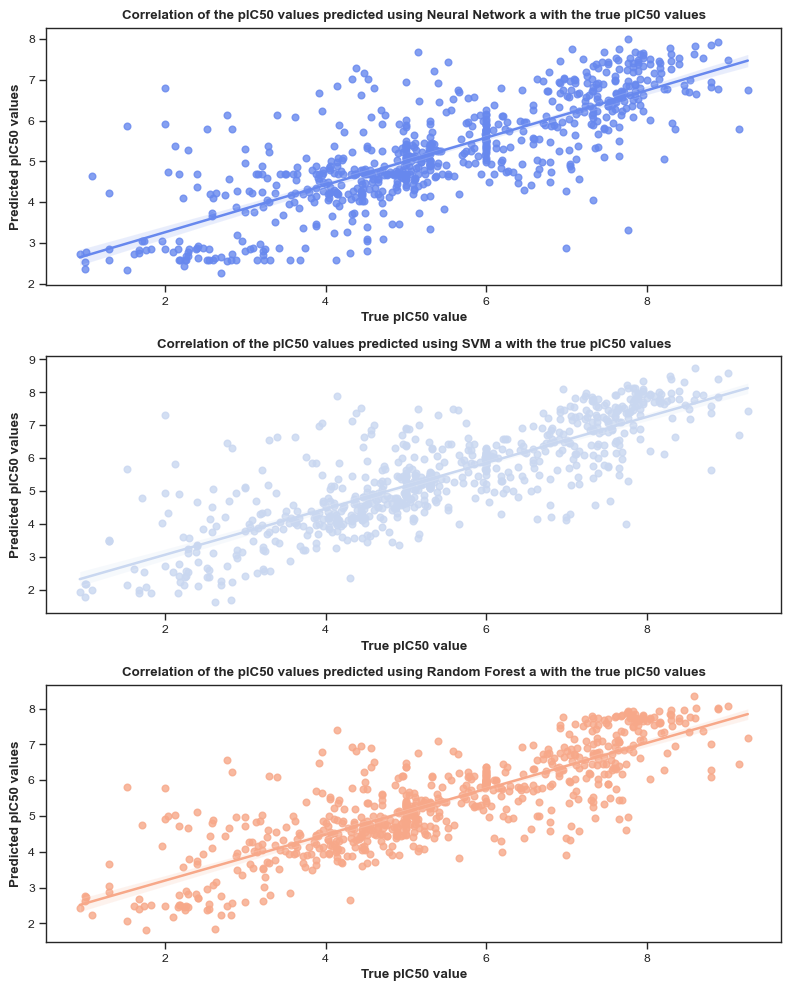

In [75]:
# we can compare these in correlation plots: 
fig, axs = plt.subplots(nrows=3, figsize=(8,10))
predictions = [y_pred, y_pred_svm, y_pred_rf]
method_names = ['Neural Network', 'SVR', 'Random Forest']
for i, pred in enumerate(predictions):
    color = color_palette[int(i/len(predictions) * len(color_palette))]
    sns.regplot(x=y_true, y=pred, ax=axs[i], color=color)
    axs[i].set_title(f'Correlation of the pIC50 values predicted using {method_names[i]} a with the true pIC50 values', fontweight='bold')
    axs[i].set_ylabel(f'Predicted pIC50 values', fontweight='bold')
    axs[i].set_xlabel(f'True pIC50 value', fontweight='bold')
fig.tight_layout()

### Optimising the NN and visualising the different changes:
Using code based on: https://github.com/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb

In [64]:
from time import time
from sklearn.model_selection import StratifiedKFold, cross_val_score
import importlib
from copy import deepcopy
from keras.layers import BatchNormalization

class SequentialModel:
  """
  The base class for a Neural Networks model
  """
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               epochs, batch_size, dropout, metrics=['accuracy']):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = [num_units, 1]
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.dropout = dropout
    
    # Initialize the sequential model
    self.model = Sequential()

    
  def build_model(self):
    """
    Adds layers and compiles the model, includes dropout
    """
    # Ensure num_units list's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[1]
      self.num_units = [i for i in range(self.num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
 
    # Loop thru all the layers
    for i in range(self.num_layers):
      # different layers should have different setups
      if i == 0: # input and first hidden layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=self.initializer,
                             activation=self.activation))
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=1,
                             kernel_initializer=self.initializer,
                             activation=self.activation_out))
      else: # hidden layers
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=self.initializer,
                            activation=self.activation))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(rate=self.dropout)) # adding the dropout layers
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers.legacy"), 
                             self.optimizer)
    self.optimizer = optimizer_class(learning_rate=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
        
  
  def evaluate_model(self, X, y, n_splits=10):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_loss: float, the average loss based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print(f'Starting {n_splits}-fold cross-validation...".')
    
    # Use KFold for regression
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):

      # Note: Regression doesn't require one-hot encoding of labels
      self.model.fit(X[train_index],
                     y[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=0)
        
      scores = self.model.evaluate(X[test_index],
                                   y[test_index], 
                                   verbose=0)
            
      # The first item is the loss (MSE)
      score_lst.append(scores[0])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-validation. Took {:.1f} minutes.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_loss = score_lst.mean()
    sd_loss = score_lst.std()

    print(f"Mean Loss: {mean_loss}, Standard Deviation: {sd_loss}")
    return mean_loss

def get_defaults(input_dim=46, 
              num_layers=16,
              num_units=32,
              activation='relu',
              activation_out='linear',
              loss='mean_squared_error',
              initializer='glorot_uniform',
              optimizer='Adam',
              learning_rate=0.001,
              dropout=0.1,
              epochs=100, 
              batch_size=64):
  """
  Returns a dict of default hyperparameter values  
  """

  defaults = {'input_dim': input_dim, 
              'num_layers': num_layers, 
              'num_units': num_units, 
              'activation': activation, 
              'activation_out': activation_out, 
              'loss': loss, 
              'initializer': initializer, 
              'optimizer': optimizer, 
              'learning_rate': learning_rate,
              'dropout': dropout, 
              'epochs': epochs, 
              'batch_size': batch_size}

  return defaults


def get_tuning_options(**kwargs):
  """
  Defines tuning parameter and corresponding options

  Params:
    Keyword arguments - the key words can be any of the following:
      input_dim, num_layers, num_units, activation, activation_out, 
      loss, initializer, optimizer, learning_rate, epochs, batch_size, 
      metrics=['accuracy'], one_hot=False
  Returns:
    tuning_options: Python dict made up of the given keyword, argument pairs

  """ 
  tuning_options = {}

  for param, options in kwargs.items():
    tuning_options[param] = options 

  return tuning_options


def build_eval(X, y, param_dict):
  """
  Builds a Neural Network model using the given params and returns the 
  cross-validation loss
  
  Params:
    X: np.array, the features
    y: np.array, the labels
    param_dict: Python dict containing the tuning parameters and values
  
  Returns:
    result: float, percentage loss based on cross-validation
  """
  print("Building model using param_dict:\n {}".format(param_dict))
  
  model = SequentialModel(input_dim=param_dict['input_dim'], 
                          num_layers=param_dict['num_layers'], 
                          num_units=param_dict['num_units'],
                          activation=param_dict['activation'], 
                          activation_out=param_dict['activation_out'], 
                          loss=param_dict['loss'], 
                          initializer=param_dict['initializer'], 
                          optimizer=param_dict['optimizer'], 
                          learning_rate=param_dict['learning_rate'],
                          dropout=param_dict['dropout'],
                          epochs=param_dict['epochs'], 
                          batch_size=param_dict['batch_size'])
  model.build_model()
  result = model.evaluate_model(X, y)
  
  return result


def run_test(X, y, param_dict, tuning_options=None):
  """
  Tests different parameter's accurcy using the given tuning options

  Params:
    X: np.array, the features
    y: np.array, the labels
    param_dict: Python dict containing the tuning parameters and values
    tuning_options: Python dict made up of the given keyword, argument pairs
  Returns:
    results: a dict when tuning_options is provided, otherwise a float that's the mean accuracy.

  """
  if tuning_options:
    results = {}
        
    for parameter, options in  tuning_options.items():
      results[parameter] = {}
      param_dict_temp = deepcopy(param_dict)
      
      for option in options:
        print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
        # Update the corresponding parameter
        param_dict_temp[parameter] = option
        
        try:
          results[parameter][option] = build_eval(X, y, param_dict_temp)
        except Exception as e: 
          results[parameter][option] = 'NaN'
          print('Error: {}, skipping...'.format(e))
          pass
    return results
  
  else:
    return build_eval(X, y, param_dict)

def wrangle_results(results):
    """
    Transforms the results dict into a df that's good for analysis.
    
    Params:
      results: dict, the results dict returned by the build_eval() function

    Returns:
        df_plot: pandas df, the wrangled long format dataframe
    """
    df = pd.DataFrame(results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")

    # Calculate the range and sd of each parameter group and convert to a df
    ranges = df_long.groupby('parameter').apply(lambda grp: grp.value.max() - grp.value.min())
    sd = df_long.groupby('parameter').apply(lambda grp: grp.value.std())
    spread = pd.concat([ranges, sd], axis=1).rename(columns={0: 'ranges', 1: 'sd'})
    # Join back the df
    df_spread = pd.merge(df_long, spread, how='left', left_on='parameter', right_index=True)
    # Reorder columns
    df_spread = df_spread[['parameter', 'option', 'value', 'ranges', 'sd']]
    # Remove the row with zero value
    df_spread = df_spread.query('ranges!=0')
    # Change column dtype
    df_spread['value'] = df_spread['value'].astype(float)
    # Sort the dataframe and use the resulting index to slice
    # This ensures the plot will be ordered accordingly
    idx = df_spread.sort_values(by=['ranges', 'option'], ascending=False).index
    df_plot = df_spread.loc[idx, :]
    
    return df_plot

  
def get_best_options(df):
  """
  Gets the best options for all params from the given results df
  
  Params:
    df: the results df returned by the wrangle_results() function
  
  Returns:
    best_options: a list of list containing param and value.
  
  """
  best_options = df.groupby('parameter').apply(lambda grp: grp.nsmallest(1, 'value'))[['parameter', 'option']].values.tolist()
  
  return best_options  


def visualize_distribution(df):
  """
  Visualizes the result distribution using boxplot and swarmplot
  
  Params:
    df: pandas df, the wrangled results df returned by the wrangle_results function
  """
  fig, ax = plt.subplots(figsize=(16, 12))
  df['value'] =  df['value'].astype(float)
  sns.boxplot(x='parameter', y='value', data=df, ax=ax)
  sns.swarmplot(x='parameter', y='value', data=df, size=12, ax=ax)
  ax.set_xlabel('Parameters',size=16)
  ax.set_ylabel('Loss',size=16)
  fig_title = 'Parameter Tuning Results Distribution'
  ax.set_title(fig_title, y=1.05, fontsize=30)

def visualize_trend(df):
  """
  Visualizes the result trend using line plot
  
  Params:
    df: pandas df, the wrangled results df returned by the wrangle_results function.
  """
  fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(30, 12))
  axes = axes.flatten()
  # Get the parameter list
  params = df.parameter.unique().tolist()
  # Loop thru the axes
  for i, ax in enumerate(axes):
    try:
      # Each subplot corresponds to one parameter
      param = params[i]
      df_param = df.query("parameter==@param")
      df_param.plot(kind='line', x='option', y='value', ax=ax)
      # Log-transform the x-axis for learning rate to avoid mixing up
      if param == 'learning_rate':
        ax.set_xscale('log')
      # Set the x ticks and tick lables
      if param in ('initializer', 'optimizer'):
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels(df_param.option)
      ax.set_xlabel(param, fontsize=16) 
      ax.set_ylabel('Loss', fontsize=16) 
      ax.get_legend().remove()
    except:
      # Remove the axis if there are no more parameters
      fig.delaxes(ax)
  
  fig_title = 'Parameter Tuning Trend'
  fig.suptitle(fig_title, y=0.92, verticalalignment='bottom', fontsize=30)
  
  plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

seed = 7
np.random.seed(seed)

# Load the target values from 'y.csv'
path_y = 'y.csv'
y_df = pd.read_csv(path_y)
y = y_df['pIC50'].values

# Load the feature values from 'sbfs.csv'
path_x = 'sbfs.csv'
x_df = pd.read_csv(path_x)
x_df = x_df.drop('Unnamed: 0', axis=1)
x = x_df.values

x = StandardScaler().fit_transform(x)

# Get baseline accuracy using defauls with the defined Neural Networks class  
param_dict_defaults, param_dict = get_defaults(), get_defaults()
accuracy_baseline = run_test(X=x, y=y, param_dict=param_dict_defaults)

# Get the tuning optioins
num_units = [8, 16, 32, 64, 128]
num_layers = [2, 4, 8, 16, 32]
loss = ['mean_absolute_error', 'mean_squared_error', 'cosine_similarity']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
dropout_rates = [0, 0.1, 0.2, 0.3]
optimizer = ['Adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [20, 40, 80, 100, 150]
batch_size = [8, 16, 32, 64]

tuning_options = get_tuning_options(num_units=num_units, 
                                    num_layers=num_layers, 
                                    loss=loss, 
                                    initializer=initializer,
                                    learning_rate=learning_rate,
                                    dropout=dropout_rates,
                                    optimizer=optimizer, 
                                    epochs=epochs, 
                                    batch_size=batch_size)

# Test all the tuning options
results = run_test(X=x, y=y, 
                   param_dict=param_dict_defaults,
                   tuning_options=tuning_options)

In [42]:
df = wrangle_results(results)
df

/var/folders/vt/9hgnpt5x74b3vhw686s6hs8m0000gn/T/ipykernel_988/906850266.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spread['value'] = df_spread['value'].astype(float)


,parameter,option,value,ranges,sd
74,loss,mean_squared_error,3.529146,4.529146,2.269873
73,loss,mean_absolute_error,0.996046,4.529146,2.269873
75,loss,cosine_similarity,-1.000000,4.529146,2.269873
187,dropout,0.3,2.270629,3.596892,1.511408
186,dropout,0.2,3.872521,3.596892,1.511408
183,dropout,0.1,2.830964,3.596892,1.511408
185,dropout,0,0.275629,3.596892,1.511408
267,batch_size,64,3.930959,3.244041,1.524574
266,batch_size,32,1.257672,3.244041,1.524574
265,batch_size,16,0.686918,3.244041,1.524574


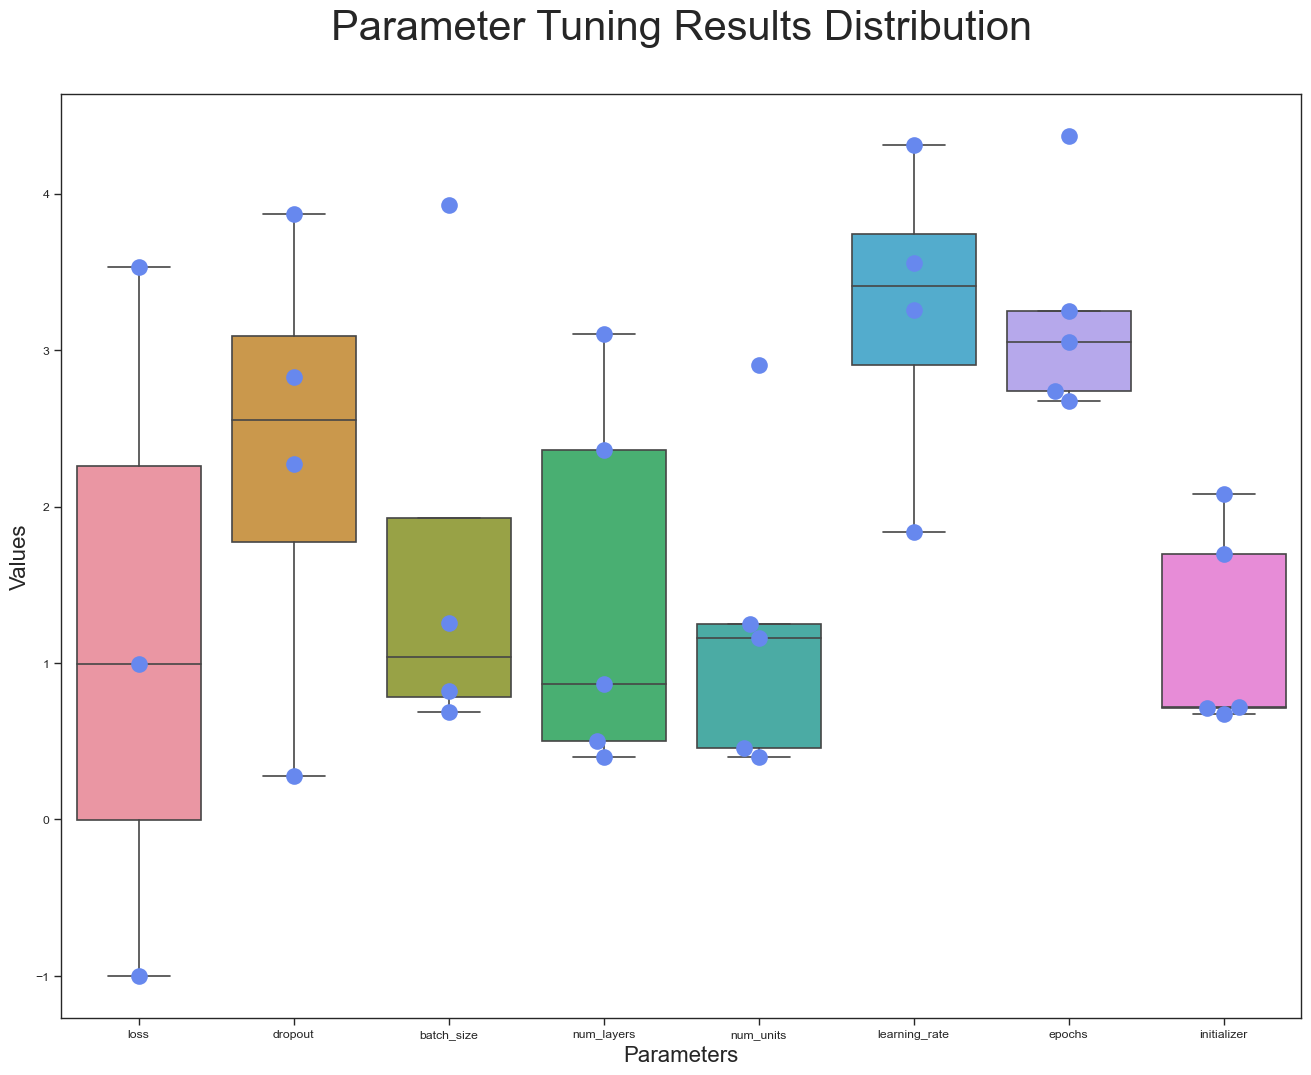

In [43]:
visualize_distribution(df)

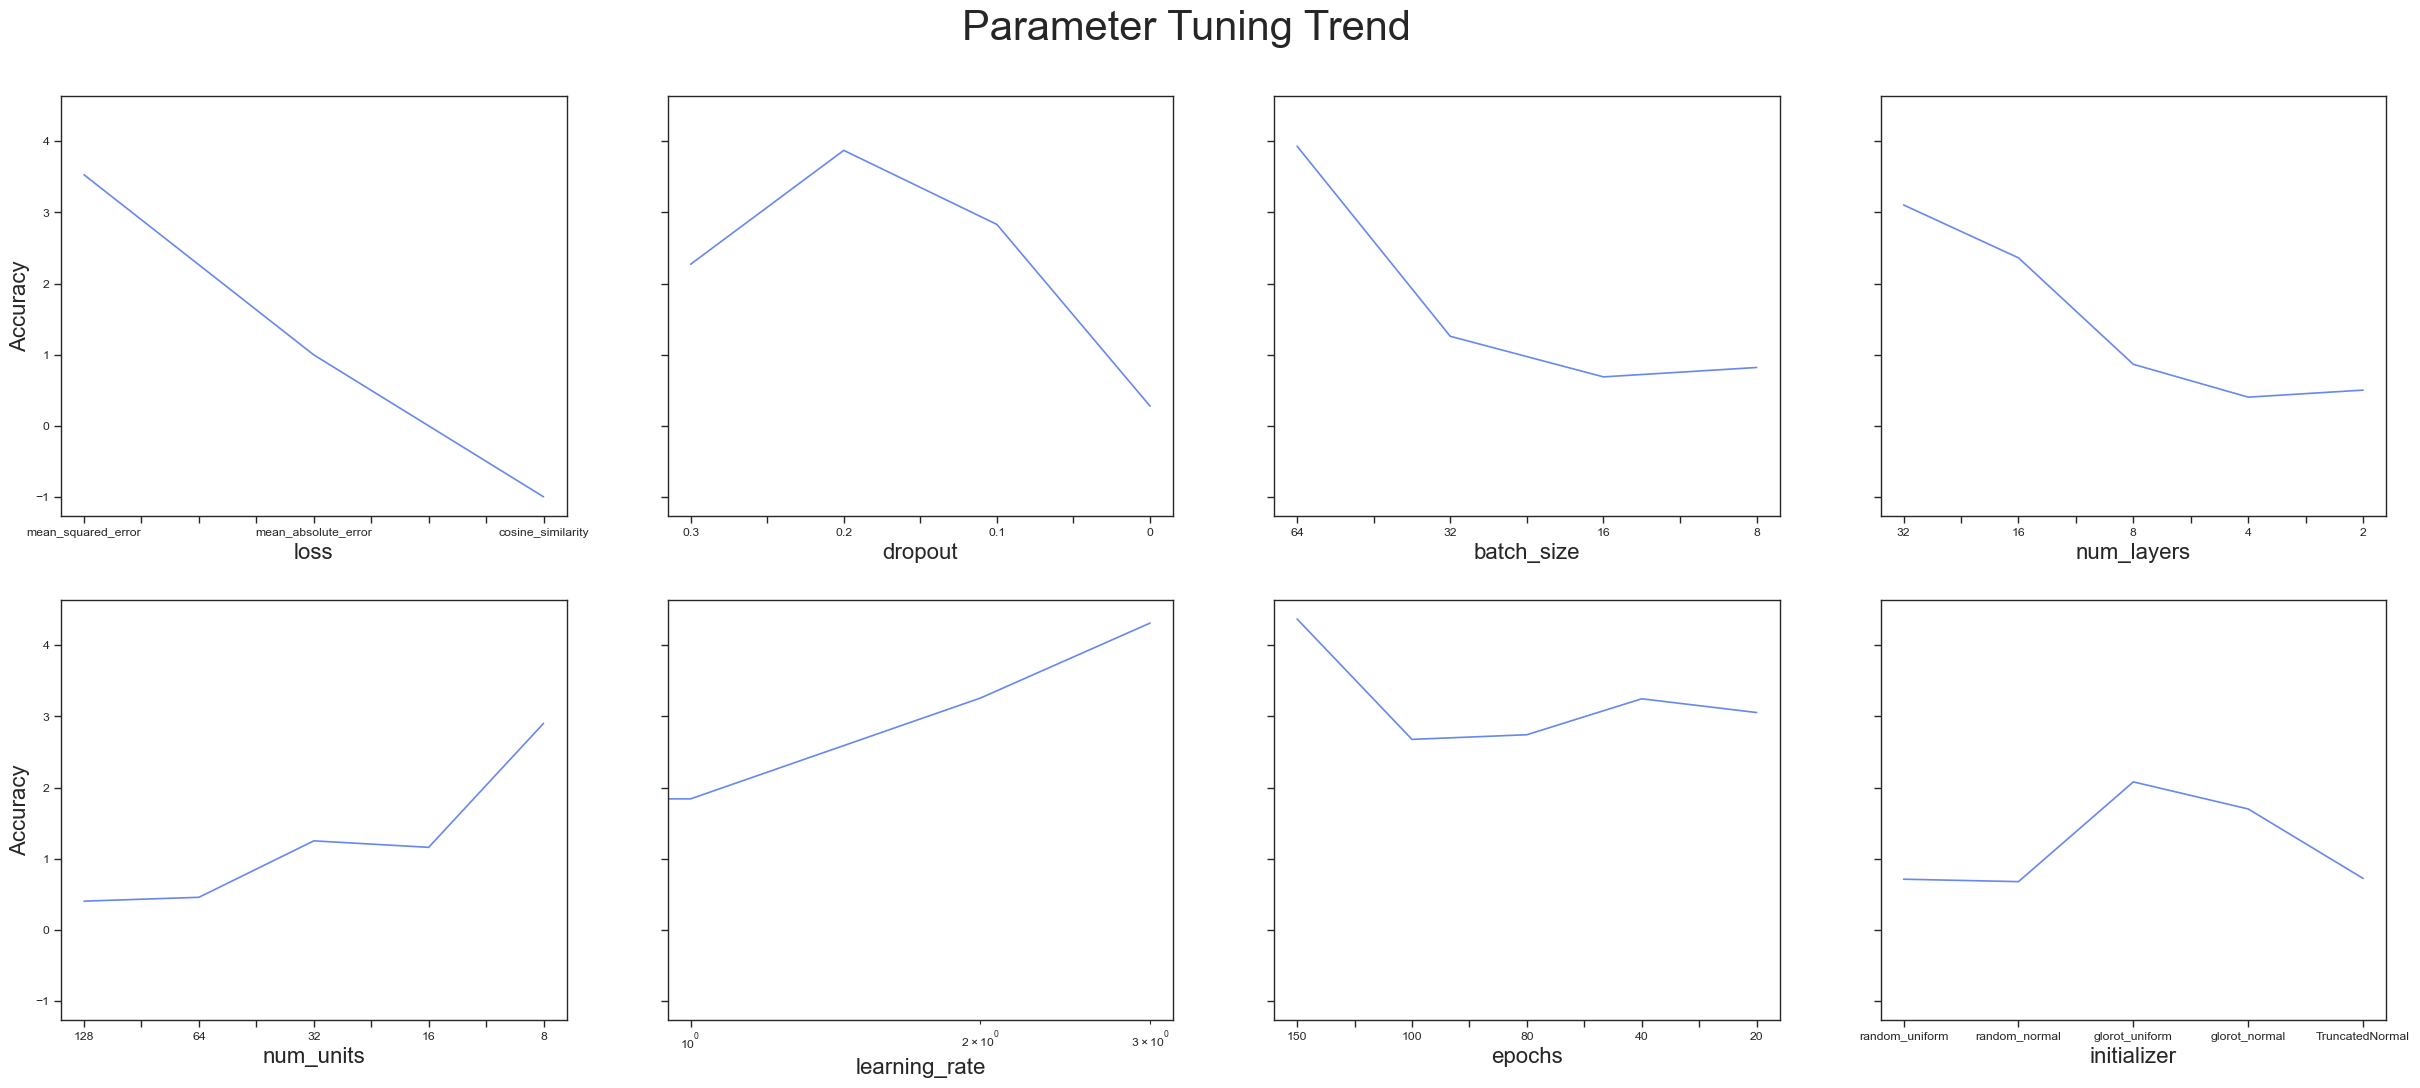

In [44]:
visualize_trend(df)

In [55]:
best_options = get_best_options(df)
print(best_options)

# setting the best results on the param_dict
for i in best_options:
  param_dict[i[0]] = i[1]
print(param_dict)

[['batch_size', 16], ['dropout', 0], ['epochs', 100], ['initializer', 'random_normal'], ['learning_rate', 0.01], ['loss', 'cosine_similarity'], ['num_layers', 4], ['num_units', 128]]
{'input_dim': 46, 'num_layers': 4, 'num_units': 128, 'activation': 'relu', 'activation_out': 'linear', 'loss': 'cosine_similarity', 'initializer': 'random_normal', 'optimizer': 'Adam', 'learning_rate': 0.01, 'dropout': 0, 'metrics': ['accuracy'], 'epochs': 100, 'batch_size': 16}


Although finding the best combination of parameters using a grid search would be more accurate, this is very time intensive, so instead we will individually optimise each parameter to try and improve the neural networks performance.

#### Building the optimal NN 

In [121]:
# Configure early stopping for the Keras model
monitor = tf.keras.callbacks.EarlyStopping(
    monitor='loss',           # Monitor the training loss
    patience=50,              # Number of epochs with no improvement to wait before stopping
    min_delta=0.001,           # Minimum change in loss to be considered an improvement
    verbose=1,                 # 0: No output, 1: Progress bar, 2: One line per epoch
    mode='auto',               # Automatically detect loss improvement direction
    restore_best_weights=True  # Restore the model with the best weights observed during training
)

# Set a random seed for reproducibility
seed = 7
np.random.seed(seed)

# Load the target values from 'y.csv'
path_y = 'y.csv'
y_df = pd.read_csv(path_y)
y = y_df['pIC50'].values

# Load the feature values from 'sbfs.csv'
path_x = 'sbfs.csv'
x_df = pd.read_csv(path_x)
x_df = x_df.drop('Unnamed: 0', axis=1)
x = x_df.values

x = StandardScaler().fit_transform(x)

# build the optimal NN model: 
# note this could be build up using the param_dict above, but I wanted to show the optimal parameter choices explicitly: 
model = SequentialModel(input_dim=46, 
                          num_layers=4, 
                          num_units=128,
                          activation='relu', 
                          activation_out='linear', 
                          loss='mean_absolute_error', 
                          initializer='random_normal', 
                          optimizer='Adam', 
                          learning_rate=0.01,
                          dropout=0,
                          epochs=100, 
                          batch_size=16)
model.build_model()

# Split the data into training and holdout sets (2/3 training, 1/3 holdout)
x, x_holdout, y, y_holdout = train_test_split(x, y, test_size=1/3)  

kf = KFold(n_splits=5, shuffle=True)

y_true = []
y_pred = []
y_pred_svm = []
y_pred_rf = []

y_true_holdout = []
y_pred_holdout = []
y_pred_svm_holdout = []
y_pred_rf_holdout = []

for train, test in kf.split(x):
    
    history = model.model.fit(x[train],
                        y[train],
                        epochs=150,
                        verbose=0,
                        validation_data=(x[test], y[test]),
                        callbacks=[monitor])

    y_pred.append(model.model.predict(x[test]))
    y_true.append(y[test])

    y_pred_holdout.append(model.model.predict(x_holdout))
    y_true_holdout.append(y_holdout)

    svm = SVR(C=4, kernel='rbf', epsilon=0.12).fit(x[train], y[train])
    y_pred_svm.append(svm.predict(x[test]))

    y_pred_svm_holdout.append(svm.predict(x_holdout))

    rf = RandomForestRegressor(n_estimators=4096, n_jobs=-1, max_features=0.3, min_samples_split=2).fit(x[train], y[train])
    y_pred_rf.append(rf.predict(x[test]))

    y_pred_rf_holdout.append(rf.predict(x_holdout))

y_true = np.ravel(np.concatenate(y_true))
y_pred = np.ravel(np.concatenate(y_pred))
y_pred_svm = np.ravel(np.concatenate(y_pred_svm))
y_pred_rf = np.ravel(np.concatenate(y_pred_rf))

y_true_holdout = np.ravel(np.concatenate(y_true_holdout))
y_pred_holdout = np.ravel(np.concatenate(y_pred_holdout))
y_pred_svm_holdout = np.ravel(np.concatenate(y_pred_svm_holdout))
y_pred_rf_holdout = np.ravel(np.concatenate(y_pred_rf_holdout))

12/12 [==============================] - 0s 690us/step
Restoring model weights from the end of the best epoch: 76.
Epoch 126: early stopping
12/12 [==============================] - 0s 1ms/step
Restoring model weights from the end of the best epoch: 40.
Epoch 90: early stopping
12/12 [==============================] - 0s 642us/step
Restoring model weights from the end of the best epoch: 81.
Epoch 131: early stopping
12/12 [==============================] - 0s 1ms/step


### Visualising the model performance 

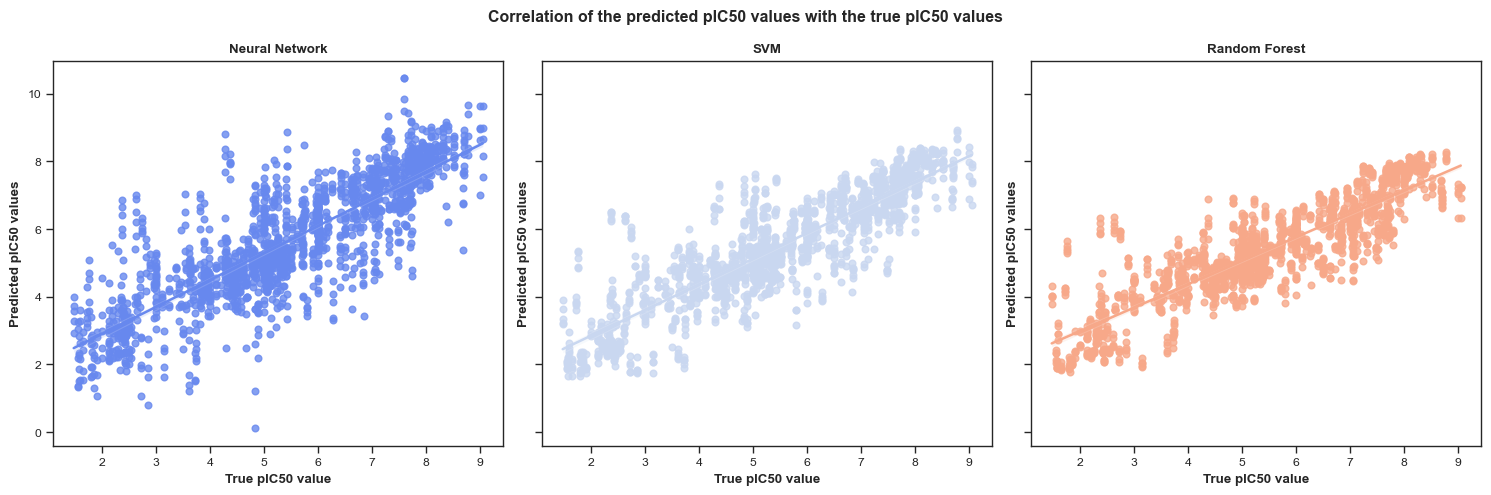

In [120]:
# we can compare these in correlation plots: 
fig, axs = plt.subplots(ncols=3, figsize=(15,5), sharey=True)
predictions = [y_pred_holdout, y_pred_svm_holdout, y_pred_rf_holdout]
method_names = ['Neural Network', 'SVM', 'Random Forest']
for i, pred in enumerate(predictions):
    color = color_palette[int(i/len(predictions) * len(color_palette))]
    sns.regplot(x=y_true_holdout, y=pred, ax=axs[i], color=color)
    axs[i].set_title(f'{method_names[i]}', fontweight='bold')
    axs[i].set_ylabel(f'Predicted pIC50 values', fontweight='bold')
    axs[i].set_xlabel(f'True pIC50 value', fontweight='bold')

fig.suptitle('Correlation of the predicted pIC50 values with the true pIC50 values', fontweight='bold')
fig.tight_layout()

Next we can calculate the R^2 values:

In [118]:
for i, pred in enumerate(predictions):
    corr_matrix = np.corrcoef(y_true_holdout, pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    print(f'R^2 value for {method_names[i]} = {R_sq}')

R^2 value for Neural Network = 0.6989485118935779
R^2 value for SVM = 0.7593558601770994
R^2 value for Random Forest = 0.7653247030571487


As we can see our neural network performs worse vs the SVM and the Random Forest models. In future we could include other hyperparameters in order ot improve the models performance. Other considerations could be using a different NN architecture in the future, or learning rate scheduling to help improve performance. Unfortunately we couldn't recreate the performance seen in the paper, although there were some differences including the optimum number of features being 10 in the paper and 46 in this notebook, as well as not using the grid search that the paper used perhaps meaning we did not use the optimum combination of hyperparameters. 